# Derive the overall highly / lowly connected CpGs (across all latent features)

- NOTE: calculation using connectivities VS perturbation 
  - connectivities: weigh each latent feature similar; latent feature with less activation (and therefore less perturbations) are not less important globally
  - perturbation: weighs latent feature differentially; latent features with higher activation have more weight

--> which approach is better?! compared it and not much difference in results. staying with connectivities for now due to the weighing argument

In [6]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
from scripts.perturbations import latSpacePerturbation_quantileCutoff
import seaborn as sns
import os
import matplotlib.pyplot as plt

import random
import copy

from scipy.stats import mannwhitneyu

sns.set_theme(style="ticks", font_scale=1.5)

In [2]:
# Load CpG conncetions
CHR = "chr22"
PATH_dir = f"results/{CHR}/perturbations"
conn = pd.read_csv(f"{PATH_dir}/quantileCutoff_CpGfocus.csv", index_col=0)

chr22


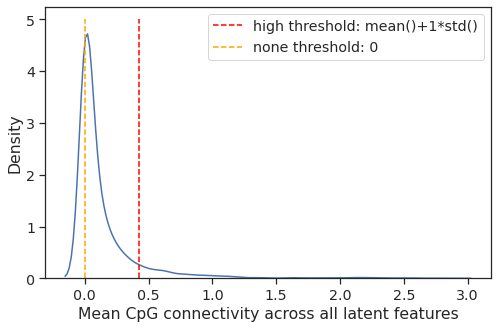

MannwhitneyuResult(statistic=1300606.0, pvalue=1.3432025122819169e-263)
MannwhitneyuResult(statistic=5542926.0, pvalue=0.0)


In [3]:
for CHR in [f"chr{i}" for i in range(22,23)]:
    print(CHR)
    # Load CpG conncetions
    PATH_dir = f"results/{CHR}/perturbations"
    conn = pd.read_csv(f"{PATH_dir}/quantileCutoff_CpGfocus.csv", index_col=0)
    # conn.mean(axis=1).sort_values(ascending=False)

    ### Find out which CpGs are overall very perturbed --> same strategy as before; find mean() an std() and grab CpGs higher than mean()+1*std()
    factor = 1
    m = conn.mean().mean()
    s = factor*conn.mean().std()

    # Apply thresholds
    idx_cpgs_high = conn.columns[conn.mean() > m+s*factor].tolist()
    idx_cpgs_none = conn.columns[conn.mean() == 0].tolist()
    idx_cpgs_low = [i for i in conn.columns.tolist() if i not in idx_cpgs_none+idx_cpgs_high]
    
    # Visualise thresholds
    fig, ax = plt.subplots(figsize=(8,5))
    sns.kdeplot(conn.mean())
    ax.vlines(m+s*factor, 0, 5, linestyles="dashed", color="red", label=f"high threshold: mean()+{factor}*std()")
    ax.vlines(0, 0, 5, linestyles="dashed", color="orange", label="none threshold: 0")
    ax.set_xlabel("Mean CpG connectivity across all latent features")
    ax.legend()
    plt.show()

    # Save
    dic_global = {}
    dic_global["global_high"] = idx_cpgs_high
    dic_global["global_low"] = idx_cpgs_low
    dic_global["global_none"] = idx_cpgs_none
    pickle.dump(dic_global, open(os.path.join(PATH_dir, "global_connectivity_groups.pkl"), "wb"))

    print(mannwhitneyu(conn.loc[:,idx_cpgs_high].mean(), conn.loc[:,idx_cpgs_low].mean()))
    print(mannwhitneyu(conn.loc[:,idx_cpgs_low].mean(), conn.loc[:,idx_cpgs_none].mean()))

#     fig, ax = plt.subplots(figsize=(8,5))
#     sns.kdeplot(conn.loc[:,idx_cpgs_none].mean())
#     sns.kdeplot(conn.loc[:,idx_cpgs_low].mean())
#     sns.kdeplot(conn.loc[:,idx_cpgs_high].mean())
#     ax.vlines(m+s, 0, 5, linestyles="dashed", color="red")
#     plt.show()


## Plot

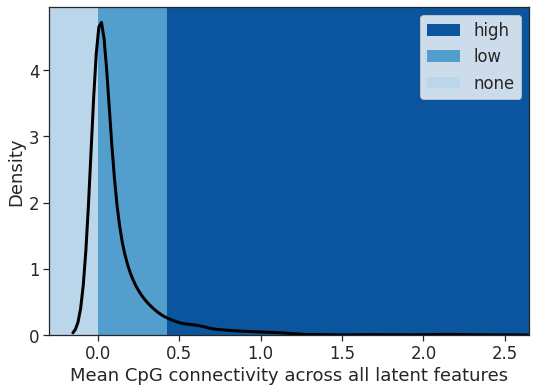

In [9]:
plt.rcParams.update({'font.size': 25})

c_high = sns.color_palette("Blues")[5]
c_low = sns.color_palette("Blues")[3]
c_none = sns.color_palette("Blues")[1]


fig, ax1 = plt.subplots(1,1, figsize=(8,6))
sns.kdeplot(conn.mean(), ax=ax1, color="black", linewidth=3)
ax1.axvspan(m+s*factor, conn.mean().max() ,facecolor=c_high, label="high", lw=0) #alpha=0.25
ax1.axvspan(0, m+s*factor,facecolor=c_low, label="low", lw=0)
ax1.axvspan(0, -.3,facecolor=c_none, label="none", lw=0)
ax1.legend()
ax1.set_xlim(-.3, 2.65)
ax1.set_xlabel("Mean CpG connectivity across all latent features")
plt.tight_layout()
plt.savefig(f"figures/methods_globalConnectivity.png")